## Modelado v3 sobre dataset de datos del log y globales sobre actividades

En este notebook se seguirá el mismo enfoque que en el anterior, y el único cambio será el dataset que se va a emplear y el preprocesamiento que se hará sobre él.

## Configuración e imports

In [2]:

import joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import randint, uniform, loguniform
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_predict, cross_validate
      
)


from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score,
    precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
)


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

from scikeras.wrappers import KerasClassifier
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam



SEED       = 42                       # determinismo
DATA_PATH  = "/home/carlos/Documentos/TFG/spark-workspace/data/datasets/dataset_2.0.parquet"
RESULTS    = Path("results/models_v3.1")
RESULTS.mkdir(exist_ok=True, parents=True)
N_JOBS     = -1                       # usa todos los cores
SCORING    = "f1"                     # métrica objetivo de la búsqueda


2025-06-29 17:11:13.903322: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-29 17:11:13.904097: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-29 17:11:13.906314: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-29 17:11:13.914797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751209873.929732  123318 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751209873.93

## Carga de datos y división 


In [3]:
## Split 80 20 
df = pd.read_parquet(DATA_PATH)   
X  = df.drop(columns=["userid", "abandona"])
y  = df["abandona"]

display(X.head())

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)
print(f"Train+val: {X_tr.shape},  Test: {X_te.shape}")


,nota_media_actividades,proporcion_actividades_hechas,num_accesos,num_accesos_sept,num_accesos_oct,num_accesos_nov,max_dias_sin_acceso,max_dias_consecutivos_accediendo
0,8.416667,0.857143,183,63,81,39,5,12
1,8.892857,1.000000,149,53,58,38,6,7
2,8.380953,1.000000,102,31,40,31,6,6
3,9.619047,1.000000,175,74,65,36,6,7
4,7.000000,0.857143,111,23,57,31,7,6


Train+val: (160, 8),  Test: (41, 8)


## Función que encapsula la construcción de la arquitectura de la NN


In [4]:
def build_model(meta, units=64, dr=0.3):
    n_features = meta["n_features_in_"]
    model = Sequential([
        Dense(units, activation="relu", input_shape=(n_features,)),
        Dropout(dr),
        Dense(units // 2, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

## Definición de preprocesamiento y función de construcción de pipelines


In [6]:
# --- Preprocesador único: escala todas las columnas ---
preprocessor = ColumnTransformer(
      [("scale_all", StandardScaler(), X.columns)],
      remainder="passthrough",
)

def make_pipeline(name: str, use_smote: bool, *, seed: int = SEED):
      """Devuelve un pipeline (pre -> [smote] -> clf)."""
      steps = [("pre", preprocessor)]
      
      if use_smote:
            steps.append(("smote", SMOTE(random_state=seed)))

      if name == "XGB":
            clf = XGBClassifier( # Estos valores serán modificados durante la busqueda posterior de hiperparámetros
                  n_estimators=200,
                  max_depth=4,
                  learning_rate=0.05,
                  subsample=0.8,
                  colsample_bytree=0.8,
                  eval_metric="logloss",
                  scale_pos_weight=y.value_counts()[0] / y.value_counts()[1],
                  random_state=SEED
            )
      elif name == "NN": # Estos igual 
            ratio = y.value_counts()[0] / y.value_counts()[1]
            clf = KerasClassifier(
                  model=build_model,
                  epochs=60,
                  batch_size=16,
                  verbose=0,
                  fit__class_weight={0: 1, 1: ratio},
                  random_state=SEED
            )
      elif name == "LogReg":
            clf = LogisticRegression(
                  class_weight="balanced",
                  max_iter=1000,
                  random_state=SEED
            )
      elif name == "Tree":
            clf = DecisionTreeClassifier(
                  class_weight="balanced",
                  random_state=SEED
            )
      else:
            raise ValueError(f"Modelo desconocido: {name}")

      steps.append(("clf", clf))
      # Usa ImbPipeline si incluyes SMOTE; sino, Pipeline normal
      Pipe = ImbPipeline if use_smote else Pipeline
      return Pipe(steps, verbose=False)


## Definición de función de búsqueda de hiperparámetros


In [7]:

param_dist_xgb = {
    "clf__n_estimators"     : randint(150, 800),
    "clf__max_depth"        : randint(2, 10),
    "clf__learning_rate"    : uniform(0.01, 0.25),
    "clf__subsample"        : uniform(0.5, 0.5),
    "clf__colsample_bytree" : uniform(0.5, 0.5),
    "clf__gamma"            : uniform(0, 5),
    "clf__min_child_weight" : randint(1, 12),
}

param_dist_nn = {
    # suponiendo paso 'nn' (= KerasClassifier vía scikeras)
    "clf__model__units"          : randint(32, 256),
    "clf__model__dr"             : uniform(0.1, 0.4),
    "clf__optimizer__learning_rate": loguniform(1e-4, 1e-2),
    "clf__epochs"                : randint(40, 120),
    "clf__batch_size"            : [8, 16, 32],
}

cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

def tune(model_name, use_smote, param_dist, n_iter=40):
    pipe = make_pipeline(model_name, use_smote)
    search = RandomizedSearchCV(
        pipe, param_distributions=param_dist,
        n_iter=n_iter, scoring=SCORING, cv=cv_inner,
        n_jobs=N_JOBS, verbose=0, random_state=SEED,
        refit=False            # <——
    )
    search.fit(X_tr, y_tr)
    print(f"▶ {model_name}{'+SMOTE' if use_smote else ''}  mejor {SCORING}: {search.best_score_:.3f}")
    return search.best_params_   # <—— devolvemos solo los HP óptimos

## Búsqueda sobre XGB y NN (CV interna)


In [10]:
best_params_xgb  = tune("XGB", False,  param_dist_xgb, n_iter=60)
best_params_nn   = tune("NN" , False,  param_dist_nn , n_iter=30)

best_params_xgb_smote  = tune("XGB", True,  param_dist_xgb, n_iter=60)
best_params_nn_smote   = tune("NN" , True,  param_dist_nn , n_iter=30)

# Reconstruimos pipelines con esos parámetros
xgb_pipe = make_pipeline("XGB", False).set_params(**best_params_xgb)
nn_pipe  = make_pipeline("NN" , False).set_params(**best_params_nn)

xgb_pipe_smote = make_pipeline("XGB", True).set_params(**best_params_xgb)
nn_pipe_smote  = make_pipeline("NN" , True).set_params(**best_params_nn)


▶ XGB  mejor f1: 0.607


2025-06-25 17:53:49.033137: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-25 17:53:49.035740: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-25 17:53:49.037324: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-25 17:53:49.039082: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-25 17:53:49.041451: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your

▶ NN  mejor f1: 0.546
▶ XGB+SMOTE  mejor f1: 0.533


/home/carlos/Documentos/TFG/spark-workspace/pyspark-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/carlos/Documentos/TFG/spark-workspace/pyspark-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/carlos/Documentos/TFG/spark-workspace/pyspark-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(

▶ NN+SMOTE  mejor f1: 0.539


## Validación cruzada externa para todos los modelos


In [11]:
scoring = ["f1", "roc_auc", "precision", "recall"]


cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

models = {
      "XGB+SMOTE": xgb_pipe_smote,
      "NN+SMOTE" : nn_pipe_smote,
      "LogReg+SMOTE": make_pipeline("LogReg", True),
      "Tree+SMOTE"  : make_pipeline("Tree" , True),
      "XGB": xgb_pipe,
      "NN" : nn_pipe,
      "LogReg": make_pipeline("LogReg", False),
      "Tree"  : make_pipeline("Tree" , False),
}

val_scores = {}
for name, mdl in models.items():
    scores = cross_validate(
        mdl, X_tr, y_tr, cv=cv_outer, scoring=scoring, n_jobs=N_JOBS
    )
    val_scores[name] = {m: scores[f"test_{m}"].mean() for m in scoring}
pd.DataFrame(val_scores).T.sort_values("f1", ascending=False)


/home/carlos/Documentos/TFG/spark-workspace/pyspark-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/carlos/Documentos/TFG/spark-workspace/pyspark-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/carlos/Documentos/TFG/spark-workspace/pyspark-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(

,f1,roc_auc,precision,recall
XGB,0.607273,0.824074,0.578095,0.653333
LogReg+SMOTE,0.546872,0.824815,0.498095,0.693333
NN,0.545641,0.770114,0.606111,0.580000
LogReg,0.500851,0.818006,0.472479,0.613333
NN+SMOTE,0.461752,0.735954,0.615909,0.500000
XGB+SMOTE,0.449356,0.796410,0.327955,0.733333
Tree,0.372727,0.614074,0.533333,0.346667
Tree+SMOTE,0.345983,0.623647,0.323333,0.433333


## Entrenamiento final de los modelos sobre el training set 


In [12]:
trained = {}
for name, mdl in models.items():
    mdl.fit(X_tr, y_tr)                    # ahora sí: sobre todo el 80 %
    joblib.dump(mdl, RESULTS / f"{name}.pkl")
    trained[name] = mdl


/home/carlos/Documentos/TFG/spark-workspace/pyspark-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1750867570.790224  663582 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1750867570.790970  663582 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-06-25 18:06:10.937

## Carga de los modelos guardados en disco

In [8]:
# --- 4. Carga de los modelos entrenados desde disco ---
loaded_models = {}
# Itera sobre todos los archivos .pkl en el directorio de resultados
for model_path in RESULTS.glob("*.pkl"):
    model_name = model_path.stem  # Extrae el nombre del modelo del nombre del archivo
    print(f"Cargando modelo: {model_name}...")
    loaded_models[model_name] = joblib.load(model_path)

print("\n¡Modelos cargados exitosamente!")

Cargando modelo: LogReg+SMOTE...
Cargando modelo: Tree+SMOTE...
Cargando modelo: XGB+SMOTE...
Cargando modelo: LogReg...
Cargando modelo: XGB...
Cargando modelo: NN+SMOTE...


E0000 00:00:1751209893.056890  123318 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1751209893.057562  123318 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Cargando modelo: Tree...
Cargando modelo: NN...

¡Modelos cargados exitosamente!


## Evaluación sobre test set


In [9]:
metrics = {}
for name, mdl in loaded_models.items():
    y_prob = mdl.predict_proba(X_te)[:,1]
    y_pred = (y_prob >= 0.50).astype(int)
    metrics[name] = {
        "f1"       : f1_score(y_te, y_pred),
        "precision": precision_score(y_te, y_pred),
        "recall"   : recall_score(y_te, y_pred),
        "roc_auc"  : roc_auc_score(y_te, y_prob)
    }

pd.DataFrame(metrics).T.sort_values("f1", ascending=False)


,f1,precision,recall,roc_auc
XGB,0.631579,0.500000,0.857143,0.840336
NN,0.588235,0.500000,0.714286,0.739496
LogReg+SMOTE,0.500000,0.444444,0.571429,0.743697
Tree+SMOTE,0.500000,0.444444,0.571429,0.712185
NN+SMOTE,0.500000,0.444444,0.571429,0.747899
XGB+SMOTE,0.500000,0.352941,0.857143,0.907563
LogReg,0.470588,0.400000,0.571429,0.760504
Tree,0.461538,0.500000,0.428571,0.670168


## Exploraciones 


### Coeficientes y odds_ratio de la LR


In [10]:
print("Coeficientes y odds_ratio del modelo de regresión logística con Smote: \n")

# Logistic Regression  ➜ coeficientes y odds-ratio
logreg = loaded_models["LogReg+SMOTE"]
coef_df = (
    pd.DataFrame({
        "feature": logreg.named_steps["pre"].get_feature_names_out(),
        "beta"   : logreg.named_steps["clf"].coef_[0]
    })
      .assign(odds_ratio=lambda d: np.exp(d.beta))
      .sort_values("beta", key=np.abs, ascending=False)
)
display(coef_df.head(15))

print("Coeficientes y odds_ratio del modelo de regresión logística sin Smote: \n")

# Logistic Regression  ➜ coeficientes y odds-ratio
logreg = loaded_models["LogReg"]
coef_df = (
    pd.DataFrame({
        "feature": logreg.named_steps["pre"].get_feature_names_out(),
        "beta"   : logreg.named_steps["clf"].coef_[0]
    })
      .assign(odds_ratio=lambda d: np.exp(d.beta))
      .sort_values("beta", key=np.abs, ascending=False)
)
display(coef_df.head(15))

Coeficientes y odds_ratio del modelo de regresión logística con Smote: 



,feature,beta,odds_ratio
7,scale_all__max_dias_consecutivos_accediendo,-1.333957,0.263433
1,scale_all__proporcion_actividades_hechas,-1.277613,0.278702
5,scale_all__num_accesos_nov,-1.270718,0.280630
4,scale_all__num_accesos_oct,0.856373,2.354606
6,scale_all__max_dias_sin_acceso,-0.596930,0.550499
2,scale_all__num_accesos,-0.072113,0.930426
3,scale_all__num_accesos_sept,0.019320,1.019507
0,scale_all__nota_media_actividades,0.003266,1.003271


Coeficientes y odds_ratio del modelo de regresión logística sin Smote: 



,feature,beta,odds_ratio
5,scale_all__num_accesos_nov,-1.066674,0.344151
1,scale_all__proporcion_actividades_hechas,-0.799725,0.449453
7,scale_all__max_dias_consecutivos_accediendo,-0.786410,0.455477
4,scale_all__num_accesos_oct,0.750180,2.117382
6,scale_all__max_dias_sin_acceso,-0.427806,0.651938
0,scale_all__nota_media_actividades,-0.258650,0.772094
3,scale_all__num_accesos_sept,-0.161994,0.850446
2,scale_all__num_accesos,-0.116801,0.889762


### Estructura del arbol de decisión


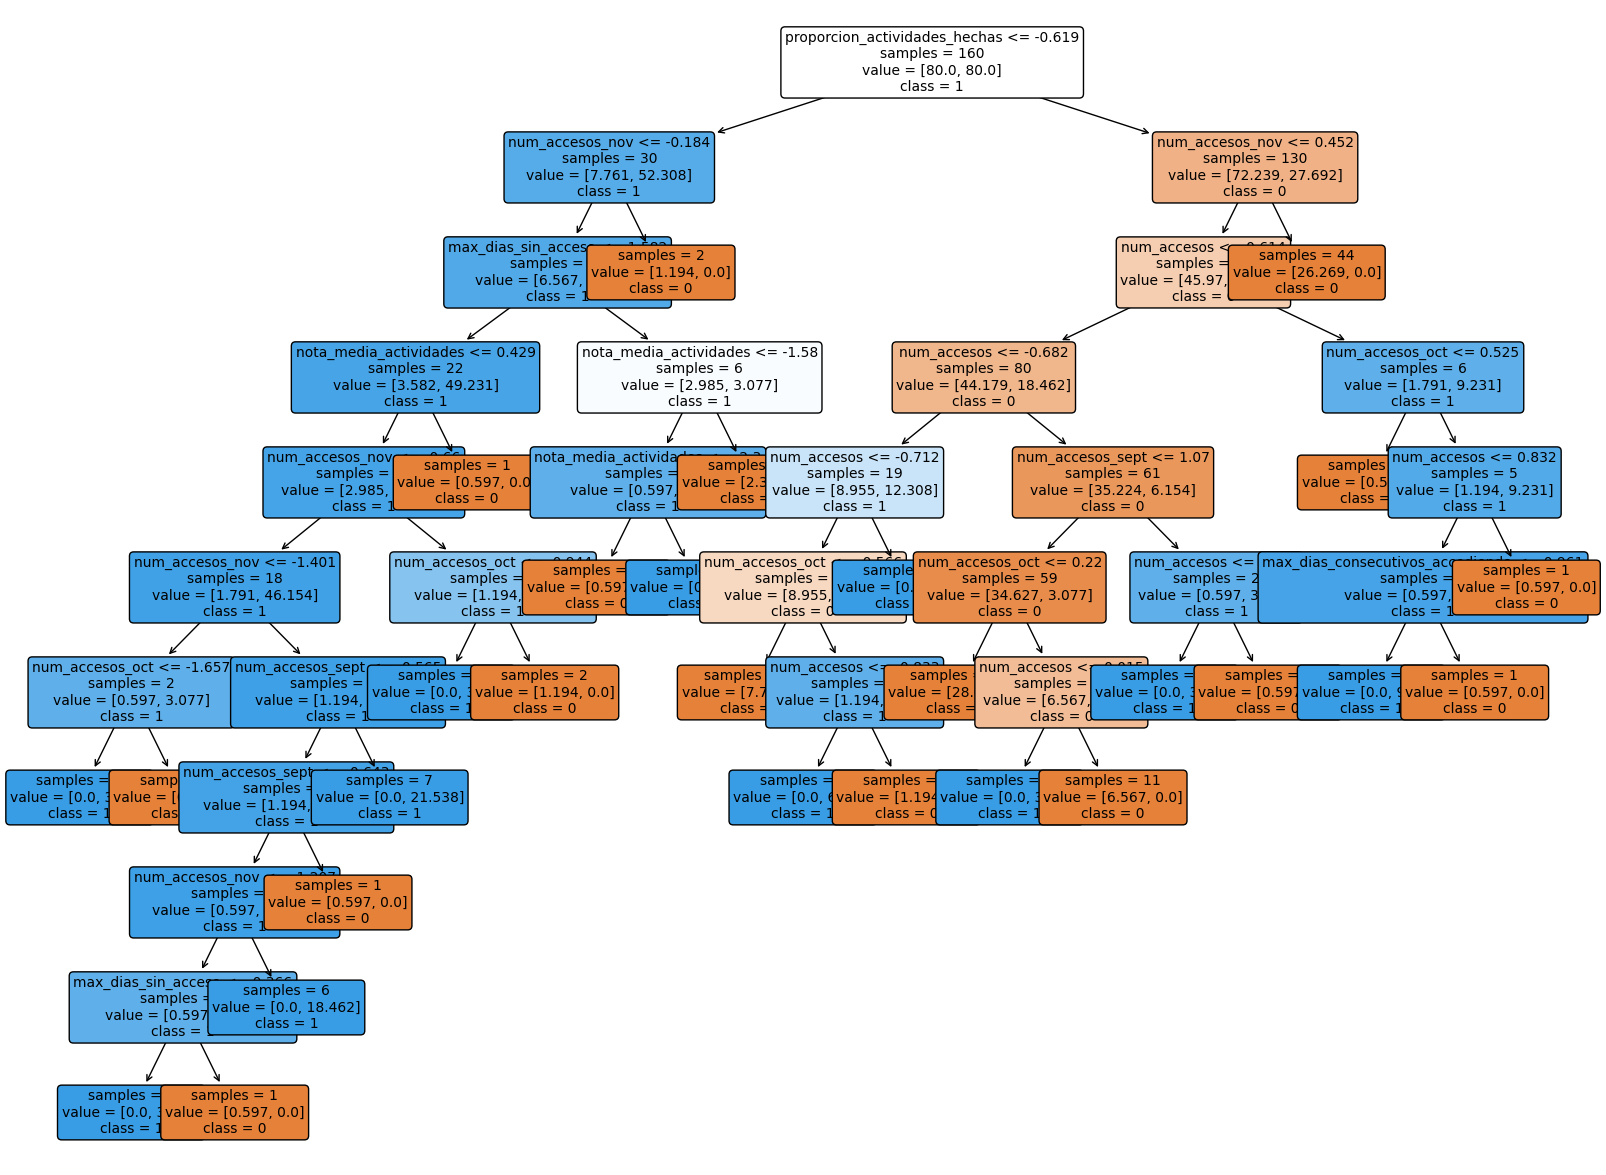

In [11]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Asume que 'models["Tree"].named_steps["clf"]' es tu modelo de árbol de decisión ya entrenado
# y 'X.columns' son los nombres de tus características.

plt.figure(figsize=(20, 15)) # Ajusta el tamaño para que sea legible

plot_tree(
    loaded_models["Tree"].named_steps["clf"],
    feature_names=list(X.columns),
    class_names=[str(c) for c in loaded_models["Tree"].named_steps["clf"].classes_], # Asegúrate de que sean los nombres de tus clases
    filled=True, # Rellena los nodos con colores para las clases
    rounded=True, # Bordes redondeados para los nodos
    impurity=False, # Si quieres quitar el gini de cada nodo
    node_ids=False, # Si quieres quitar los IDs de los nodos (a menudo irrelevante para el análisis)
    fontsize=10 # Ajusta el tamaño de la fuente si es necesario
)

plt.show()


## Exploración de curva PR, decisión de umbral y matriz de confusión sobre el mejor modelo


▶ Mejor modelo: XGB  –  threshold óptimo ≈ 0.665


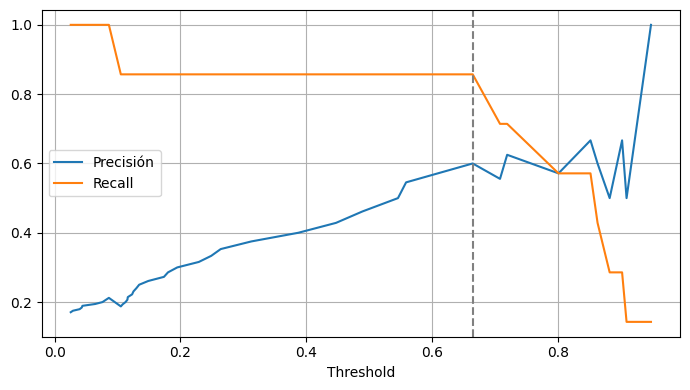

F1=0.706  Prec=0.600  Rec=0.857  AUC=0.840


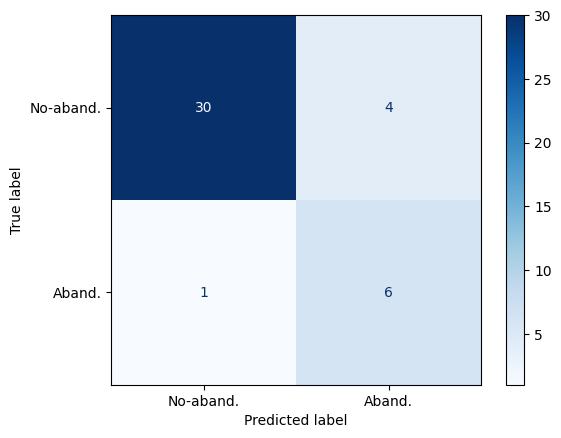

In [16]:
# Tomamos el *mejor* modelo según F1
best_name = max(metrics, key=lambda m: metrics[m]["f1"])
best_mdl  = loaded_models[best_name]
y_prob_te = best_mdl.predict_proba(X_te)[:,1]

precision, recall, thr = precision_recall_curve(y_te, y_prob_te)

# --- CORRECCIÓN AQUÍ ---
# Calculamos F1 solo para los elementos que se corresponden con un umbral.
# Usamos [:-1] para que los arrays de P y R tengan la misma longitud que 'thr'.
f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-9)
best_thr = thr[np.argmax(f1_scores)]

print(f"▶ Mejor modelo: {best_name}  –  threshold óptimo ≈ {best_thr:.3f}")

# Curva P-R vs threshold
plt.figure(figsize=(7,4))
# Ahora el plotting usa los mismos datos que el cálculo, por lo que coincidirá
plt.plot(thr, precision[:-1], label="Precisión")
plt.plot(thr, recall[:-1], label="Recall")
plt.axvline(best_thr, ls="--", c="grey"); plt.legend()
plt.xlabel("Threshold")
# plt.title("Precision / Recall vs Threshold")
plt.grid(True); plt.tight_layout(); plt.show()

# Métricas y matriz de confusión con nuevo umbral
y_pred_best = (y_prob_te >= best_thr).astype(int)
print(f"F1={f1_score(y_te,y_pred_best):.3f}  Prec={precision_score(y_te,y_pred_best):.3f}  Rec={recall_score(y_te,y_pred_best):.3f}  AUC={roc_auc_score(y_te, y_prob_te):.3f}")

cm = confusion_matrix(y_te, y_pred_best, labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=["No-aband.","Aband."]).plot(cmap=plt.cm.Blues)
plt.show()